In [1]:
!gdown --id 1VyGxwUTIkAGkioo_eFpVDsu6Nz-DxLDF
!gdown --id 1WiFdhonUfz21EML1y41QhJdQvaHjDK5G
!gdown --id 163kdvbUENBf7mTg_QCSfGSAHsne21RRO

Downloading...
From: https://drive.google.com/uc?id=1VyGxwUTIkAGkioo_eFpVDsu6Nz-DxLDF
To: /content/way.jpg
100% 137k/137k [00:00<00:00, 48.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WiFdhonUfz21EML1y41QhJdQvaHjDK5G
To: /content/example.png
100% 4.49k/4.49k [00:00<00:00, 3.30MB/s]
Downloading...
From: https://drive.google.com/uc?id=163kdvbUENBf7mTg_QCSfGSAHsne21RRO
To: /content/mask.png
100% 56.8k/56.8k [00:00<00:00, 71.3MB/s]


In [2]:
import time
from functools import wraps

def calc_time(f):
  @wraps(f)
  def wrapper(*args, **kwds):
    start = time.time()
    result = f(*args, **kwds)
    elapsed = time.time() - start
    print("%s took %s" % (f.__name__, elapsed))
    return result
  return wrapper

# Affine Transform

In [3]:
class AffineTransform:
    def __init__(self):
        return None

    @calc_time
    def get_rotation_matrix2D(self, point, alpha, scale):
        cx, cy = point 
        alpha = alpha * np.pi / 180.0        

        #Translate
        T1 = np.array([[1, 0, -cx],
                       [0, 1, -cy],
                       [0, 0, 1]])
        
        #Rotate
        R = np.array([[np.cos(alpha), -np.sin(alpha), 0],
                      [np.sin(alpha), np.cos(alpha), 0],
                      [0, 0, 1]])
        
        #Scale
        S = np.array([[scale, 0, 0],
                      [0, scale, 0],
                      [0, 0, 1]])
        
        #Translate
        T2 = np.array([[1, 0, cx],
                      [0, 1, cy],
                      [0, 0, 1]])
        
        return T2 @ (S @ (R @ T1))        

    @calc_time
    def warp_affine(self, image, alpha, scale):
        h, w = image.shape
        rotation_matrix2D = self.get_rotation_matrix2D((w / 2, h / 2), alpha, scale) 
        
        new_image = np.zeros_like(image)
        for i in range(w):
            for j in range(h):
                x, y = np.dot(rotation_matrix2D, [i, j, 1]).astype(int)[:2]
                if 0 <= x < w and 0 <= y < h:
                    new_image[y, x] = image[j, i]
        return new_image

    def __call__(self, image, alpha, scale):
        return self.warp_affine(image, alpha, scale)

### Test get_rotation_matrix2D function and compare with openCV

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

t1 = time.time()
M_cv = cv2.getRotationMatrix2D((1, 1), -90, 1)
t2 = time.time()
print('Time of opencv:', t2 - t1)

rotate = AffineTransform()
M = rotate.get_rotation_matrix2D((1, 1), 90, 1)[:2, :]

print(M_cv)
print(M)

Time of opencv: 0.00010561943054199219
get_rotation_matrix2D took 0.0001556873321533203
[[ 6.12323400e-17 -1.00000000e+00  2.00000000e+00]
 [ 1.00000000e+00  6.12323400e-17 -1.11022302e-16]]
[[ 6.123234e-17 -1.000000e+00  2.000000e+00]
 [ 1.000000e+00  6.123234e-17  0.000000e+00]]


### Test on image

In [5]:
image = cv2.imread('way.jpg', 0)
h, w = image.shape

t1 = time.time()
M_cv = cv2.getRotationMatrix2D((w / 2, h / 2), -60, 1)
rotated_cv = cv2.warpAffine(image, M_cv, (w, h))
t2 = time.time()
print('Time of opencv:', t2 - t1)

affine_transform = AffineTransform()
rotated = affine_transform(image, 60, 1)

Time of opencv: 0.006570577621459961
get_rotation_matrix2D took 9.298324584960938e-05
warp_affine took 6.122110605239868


Text(0.5, 1.0, 'rotate implement')

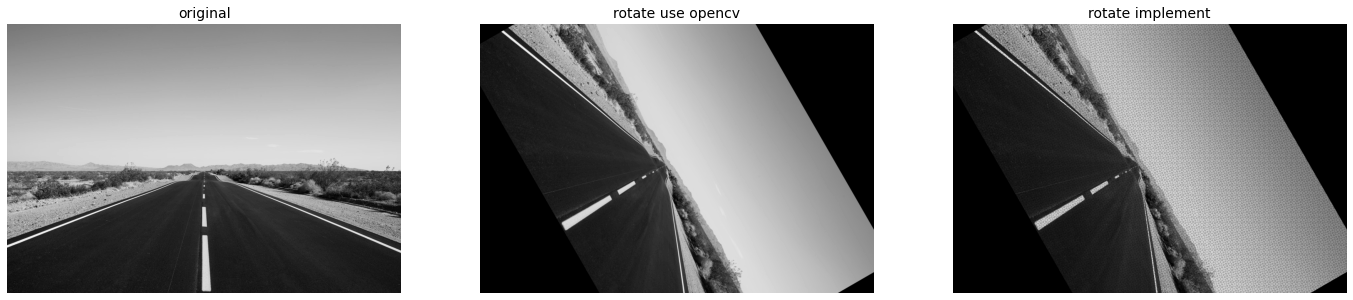

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(24, 16))
ax[0].imshow(image, cmap="gray")
ax[0].axis("off")
ax[0].set_title("original", fontsize=14)

ax[1].imshow(rotated_cv, cmap="gray")
ax[1].axis("off")
ax[1].set_title("rotate use opencv", fontsize=14)

ax[2].imshow(rotated, cmap="gray")
ax[2].axis("off")
ax[2].set_title("rotate implement", fontsize=14)

# Get mask in image

## TEST

### Convert Image to Binary Image

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('example.png')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

### Connected Components in Binary Image

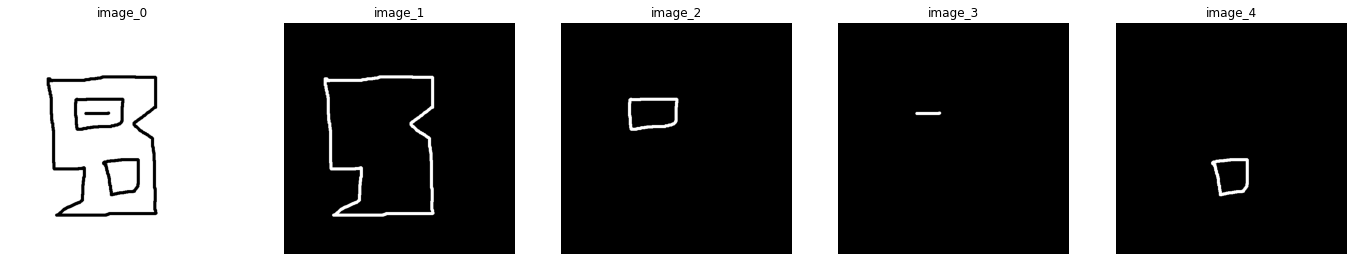

In [8]:
# find all connected components
num_labels, labels = cv2.connectedComponents(binary_image)

fig, ax = plt.subplots(1, num_labels, figsize=(24, 16))

masks = []
for i in range(0, num_labels):
    mask = (labels == i).astype(np.uint8) * 255
    if i != 0:
        masks.append(mask)
        
    ax[i].imshow(mask, cmap="gray")
    ax[i].axis("off")
    ax[i].set_title(f'image_{i}', fontsize=12)

### Contours of Binary Image

In [9]:
# find convex hull of each mask in labels
contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print('Number of contours: ', len(contours))

Number of contours:  1


### Convex Hulls

In [10]:
testing_mask = masks[0]
contours, _ = cv2.findContours(testing_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
hull = cv2.convexHull(contours[0])
polygon = np.squeeze(np.array(hull), axis=1)

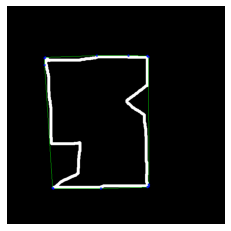

In [11]:
testing_hull = np.stack([testing_mask] * 3, axis=2)
for i, point in enumerate(polygon):
    cv2.circle(testing_hull, center=tuple(point), radius=3, color=(0, 0, 255), thickness=-1)
    cv2.line(testing_hull, pt1=tuple(polygon[i % len(polygon)]), pt2=tuple(polygon[(i + 1) % len(polygon)]), color=(0, 255, 0), thickness=1)

plt.axis('off')
plt.imshow(testing_hull)

### Approx Contours

In [12]:
testing_mask = masks[0]
contours, _ = cv2.findContours(testing_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour = contours[0]

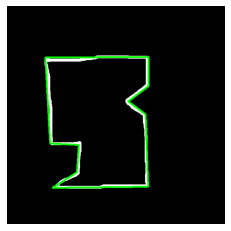

In [13]:
# contour Perimeter
perimeter = cv2.arcLength(contour, True)
# contour approximation
epsilon = 0.01 * perimeter
approx = cv2.approxPolyDP(contour, epsilon, True)
# approximation testing
testing_approximation = np.stack([testing_mask] * 3, axis=2)
cv2.drawContours(testing_approximation, [approx], -1, (0, 255, 0), 3)

plt.axis('off')
plt.imshow(testing_approximation)

### Function find convex hull of binary image

In [14]:
def find_convex_hulls(pred, binary_threshold=0.6, area_threshold=0.0, vertical_threshold=20):
    convex_hulls = []
    binary_image = (pred > binary_threshold).astype(np.uint8)
    binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, np.ones(shape=(5, 5), dtype=np.uint8))
    num_label, label = cv2.connectedComponents(binary_image)
    for i in range(1, num_label):
        contours, _ = cv2.findContours((label == i).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour = contours[0]
        if cv2.contourArea(contour) > area_threshold * pred.size:
            epsilon = 0.009 * cv2.arcLength(contour, closed=True)
            approx_contour = cv2.approxPolyDP(contour, epsilon, closed=True)
            convex_hull = cv2.convexHull(approx_contour) # approximate contour to reduce num of points
            for inc in range(5):
                if convex_hull.shape[0] <= vertical_threshold:
                    break
                epsilon = 0.002 * (1 + inc) * cv2.arcLength(contour, closed=True)
                convex_hull = cv2.approxPolyDP(convex_hull, epsilon, closed=True)

            if 4 <= convex_hull.shape[0] <= vertical_threshold:
                convex_hulls.append(np.squeeze(np.array(convex_hull), axis=1))

    return convex_hulls

In [15]:
pred = cv2.imread('example.png', cv2.IMREAD_GRAYSCALE) / 255
convex_hulls = find_convex_hulls(pred)

### IOU of 2 polygons

In [16]:
from shapely.geometry import Polygon

def compute_iou(polyA, polyB):
    iou = 0.
    polyA = Polygon(polyA)
    polyB = Polygon(polyB)
    if polyA.intersects(polyB):
        iou = polyA.intersection(polyB).area / polyA.union(polyB).area
    return iou

In [17]:
polyA = [[0, 0], [0, 2], [2, 2], [2, 0]]
polyB = [[1, 1], [1, 3], [3, 3], [3, 1]]
compute_iou(polyA, polyB)

0.14285714285714285

## Find Enclosing Quadrileteral

In [18]:
import cv2
import itertools
import numpy as np
from shapely.geometry import box, Point, Polygon


class EnclosingQuadrilateral:
    def __init__(self):
        self.binary_threshold = 0.6
        self.area_threshold = 0.0
        self.vertical_threshold = 20
        self.iou_threshold = 0.8

    def _order_points(self, points):
        assert len(points) == 4, 'Length of points must be 4'
        left = sorted(points, key=lambda p: p[0])[:2]
        right = sorted(points, key=lambda p: p[0])[2:]
        tl, bl = sorted(left, key=lambda p: p[1])
        tr, br = sorted(right, key=lambda p: p[1])
        return [tl, tr, br, bl]

    def _compute_iou(self, polyA, polyB):
        iou = 0.
        polyA = Polygon(polyA)
        polyB = Polygon(polyB)
        if polyA.intersects(polyB):
            iou = polyA.intersection(polyB).area / polyA.union(polyB).area
        return iou

    def _intersection_point(self, line1, line2):
        a1 = line1[1][1] - line1[0][1]
        b1 = line1[0][0] - line1[1][0]
        a2 = line2[1][1] - line2[0][1]
        b2 = line2[0][0] - line2[1][0]
        determinant = a1 * b2 - a2 * b1
        if determinant == 0:
            return None
        c1 = (a1 / determinant) * line1[0][0] + (b1 / determinant) * line1[0][1]
        c2 = (a2 / determinant) * line2[0][0] + (b2 / determinant) * line2[0][1]
        x = b2 * c1 - b1 * c2
        y = a1 * c2 - a2 * c1
        return [int(x), int(y)]

    def _convex_hulls(self, pred, binary_threshold=0.6, area_threshold=0.0, vertical_threshold=20):
        convex_hulls = []
        binary_image = (pred > binary_threshold).astype(np.uint8)
        binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, np.ones(shape=(5, 5), dtype=np.uint8))
        num_label, label = cv2.connectedComponents(binary_image)
        for i in range(1, num_label):
            contours, _ = cv2.findContours((label == i).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contour = contours[0]
            if cv2.contourArea(contour) > area_threshold * pred.size:
                epsilon = 0.009 * cv2.arcLength(contour, closed=True)
                approx_contour = cv2.approxPolyDP(contour, epsilon, closed=True)
                convex_hull = cv2.convexHull(approx_contour)  # approximate contour to reduce num of points
                for inc in range(5):
                    if convex_hull.shape[0] <= vertical_threshold:
                        break
                    epsilon = 0.002 * (1 + inc) * cv2.arcLength(contour, closed=True)
                    convex_hull = cv2.approxPolyDP(convex_hull, epsilon, closed=True)

                if 4 <= convex_hull.shape[0] <= vertical_threshold:
                    convex_hulls.append(np.squeeze(np.array(convex_hull), axis=1))

        return convex_hulls

    def _enclosing_quadrilateral(self, pred, convex_hulls, iou_threshold):
        enclosing_quads = []
        x1, x2 = [-pred.shape[0], 2 * pred.shape[0]]
        y1, y2 = [-pred.shape[1], 2 * pred.shape[1]]
        boundary = box(x1, y1, x2, y2)
        for polygon in convex_hulls:
            num_verticals = len(polygon)
            max_iou = 0.
            enclosing_quad = None
            for (x, y, z, t) in itertools.combinations(range(num_verticals), 4):
                lines = [
                    [polygon[x], polygon[(x + 1) % num_verticals]],
                    [polygon[y], polygon[(y + 1) % num_verticals]],
                    [polygon[z], polygon[(z + 1) % num_verticals]],
                    [polygon[t], polygon[(t + 1) % num_verticals]]
                ]
                points = []
                for i in range(4):
                    point = self._intersection_point(lines[i], lines[(i + 1) % 4])
                    if (not point) or (point in points) or (not boundary.contains(Point(point))):
                        break
                    points.append(point)

                if len(points) == 4 and Polygon(self._order_points(points)).is_valid:
                    candidate_quad = self._order_points(points)
                    iou = self._compute_iou(candidate_quad, polygon)
                    if iou > max_iou and iou > iou_threshold:
                        enclosing_quad = candidate_quad
                        max_iou = iou

            if enclosing_quad:
                enclosing_quads.append(enclosing_quad)

        return enclosing_quads

    def __call__(self, pred):
        convex_hulls = self._convex_hulls(pred, self.binary_threshold, self.area_threshold, self.vertical_threshold)
        enclosing_quads = self._enclosing_quadrilateral(pred, convex_hulls, self.iou_threshold)
        return enclosing_quads


In [19]:
import numpy as np
def distance(point1, point2):
    point1 = np.float64(point1)
    point2 = np.float64(point2)
    return np.linalg.norm(point1 - point2)

def distance2(point1, point2):
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

In [20]:
point1 = [3, 4]
point2 = [4, 3]

In [21]:
distance(point1, point2)

1.4142135623730951

In [22]:
distance2(point1, point2)

1.4142135623730951

## Warp Perspective Transform

In [23]:
def get_warped_image(image, quadrangle):
    top_left, top_right, bottom_right, bottom_left = quadrangle

    widthA = distance(bottom_right, bottom_left)
    widthB = distance(top_right, top_left)
    avgWidth = round((widthA + widthB) / 2)

    heightA = distance(top_right, bottom_right)
    heightB = distance(top_left, bottom_left)
    avgHeight = round((heightA + heightB) / 2)

    rectangle = np.float32([[0, 0], [avgWidth - 1, 0], [avgWidth - 1, avgHeight - 1], [0, avgHeight - 1]])
    
    persp_matrix = cv2.getPerspectiveTransform(quadrangle, rectangle)
    warped_image = cv2.warpPerspective(image, persp_matrix, (int(avgWidth), int(avgHeight)))

    return warped_image


In [24]:
import time
minEnclosingQuad = EnclosingQuadrilateral()
image = cv2.imread('mask.png')
pred = cv2.imread('mask.png', cv2.IMREAD_GRAYSCALE) / 255.
t1 = time.time()
enclosing_quads = minEnclosingQuad(pred)
t2 = time.time()
print(f'processing time: {t2 - t1}')

processing time: 0.00865316390991211


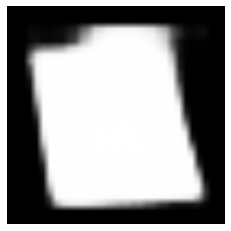

In [25]:
import matplotlib.pyplot as plt

plt.axis('off')
plt.imshow(pred, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


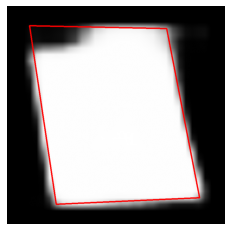

In [26]:
for quad in enclosing_quads:
    quad = np.int32(quad)
    testing_quad = np.stack([pred] * 3, axis=2)
    cv2.polylines(testing_quad, [quad], True, (255, 0, 0), 3)
    plt.axis('off')
    plt.imshow(testing_quad)

In [27]:
quadrangle = np.float32(enclosing_quads[0])
warp_image = get_warped_image(pred, quadrangle)

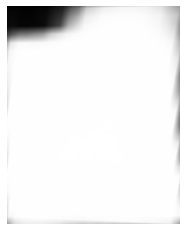

In [28]:
plt.axis('off')
plt.imshow(warp_image, cmap='gray')